# <center> Customer Segmentation for a Retail Company</center>

In [36]:
# Libraries used in the analysis are imported here for easy access
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1.0 Introduction
The case study for this project is an online retail company registered in the UK with customers from various countries. The raw dataset used for the project is available at the [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail). The analysis and exploration of this dataset will follow the CRISP-DM approach including business understanding, data understanding, data preparation/exploration, and modeling.

The focus of this project is to demonstrate expertise in Data Management, Analysis, and modeling. The project includes the establishment of an analytical Dimensional Database model using the star schema. To create more fields for the Database model, the base  dataset from UCI is augmented with generated data using the python faker library. Ultimately, only the original data is queried from the denormalized database and then used to build a segmentation model for the retail business.

# 2.0 Business Understanding

Like any typical online business, cross-selling and up-selling to existing customers is a key success factor. From their data records, the company in this case study has thousands of customers. It is inpractical to review their preferences manually and make related business decisions. It is also important for an online retail company to be aware of the habits of their customers so that they can tailor their advertisements and promotions to specific and relevant customer groups. An historical review of the trends in the customer's behaviours and preferences will help the company to unlock value by improving their ability to target existing customers based on their demonstrated preferences.

# 3.0 Data Understanding


The best way to resolve the business problem stipulated by the retail company is by creating a customer segmentation. This will use the customer information and purchase behaviour to group customers. Customers in the same class will be considered to have similar behaviour and thus make similar purchase decisions. The recommendation system will offer recommendations based on the classes.  In the meantime, an exploratory analysis of their existing data can be carried out to unlock immediate value while the model development is ongoing. This exploratory analysis is the focus of this project.

Information on the customers will be required to complete this analysis. The data on purchase history including prices, frequency of purchase, and originating country will be retrieved from the company to complete the analysis.

The company maintains a normalized database that is optimized for their transaction processing. A new database will be created that is optimized for analytical processing. It will be a denormalized dimensional model implemented in PostgreSQL.

The original data for the analysis contains the following features. There are no missing values in the data.

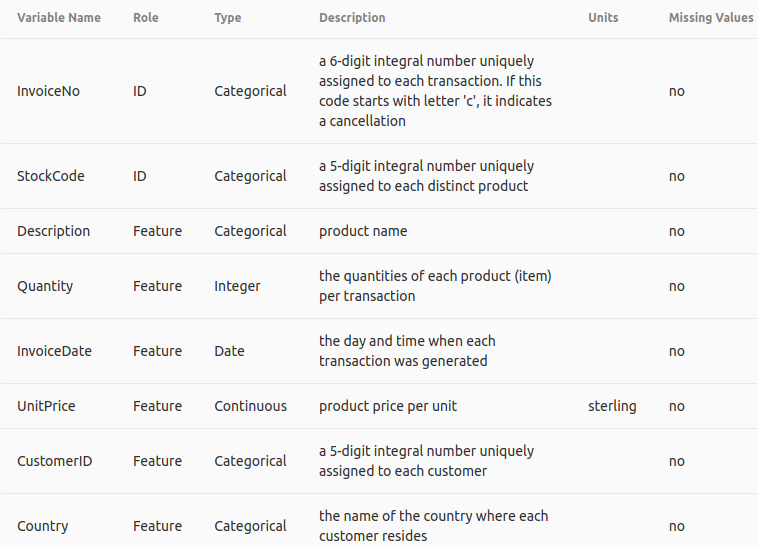  
source: [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail)

# 3.1 Dimensional Modeling

Strictly speaking, a dimensional model is not required for this analysis. The required data could simply be extracted from the existing database using a simple SQL statement. A dimensional model will be created to demonstrate prowess in creating, denomalizing and querying SQL databases using various tools including bash scripting, python, and GUI.

## 3.1.1 Data Augmentation

In order to create more data fields for the model, a [python script](https://github.com/asoyewole/Datascience-Projects/blob/main/data_generation_script.py) is used to create additional data to augment the customer information from UCI. Additional data including Firstname, Lastname, Address, Phone, Email, and Password were created for all rows in the original dataset. 

In retrospect, creating a password column was unnecessary because user passwords will typically not form part of the data available to analysts. Additionally, handling passwords securely in a database requires encryption (hashing with Bcrypt or scrypt, salting) such that in essence, even the DataBase Administrator has no access to the raw passwords.

None of the 'fake' data will be used in the actual segmentation analysis.

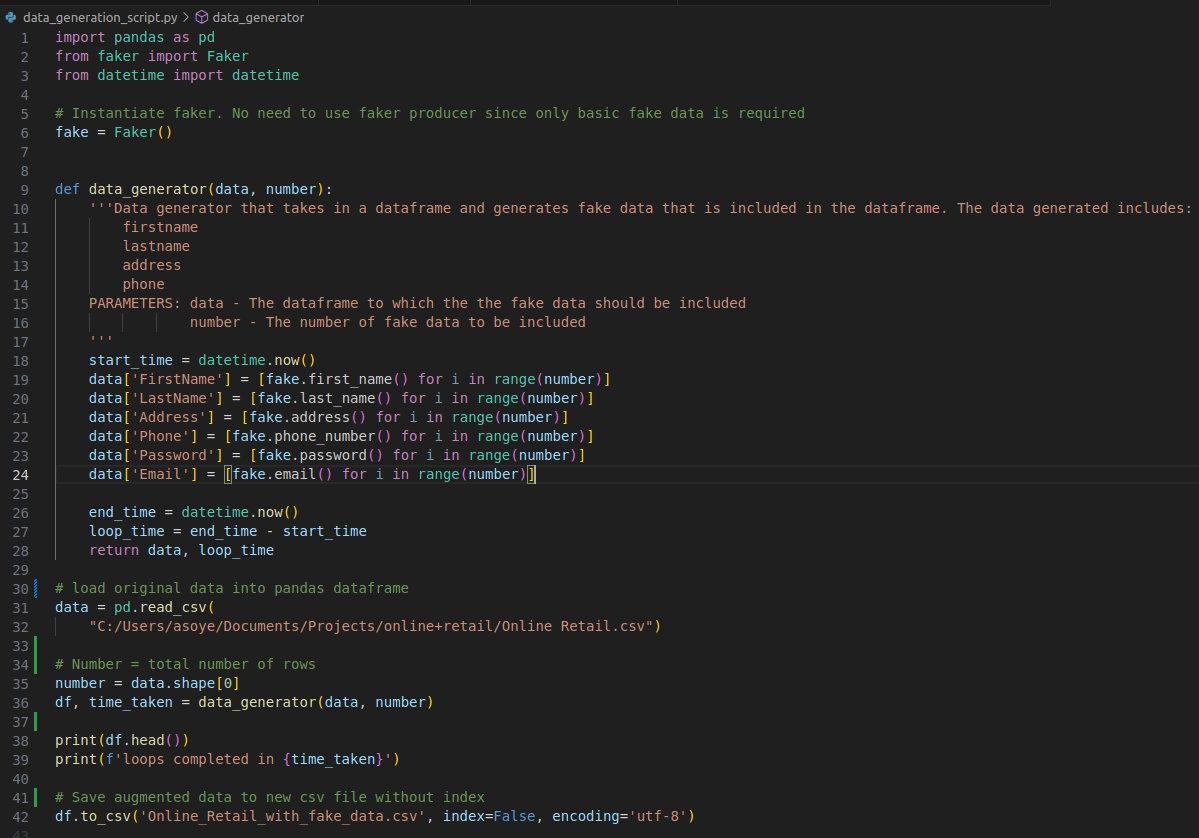  
Data generation script to augment original data with customer information.

## 3.1.2 Conceptual Model

The ERD (Entity Relationship Diagram) tool of PGAdmin4 was used to develop the conceptual model for the dimensional model. The fields available in the augmented data was spread across three tables based on how the dimensions relate with the measure. The tables in the dimensional model include Customer_dim, stock_dim and sales_measure. New fields were included in the dimension tables to serve as the primary key. They are serial, self-incrementing integers starting from one (1). The one to many relationships between the dimensions and the measure was established using foreign keys.  A staging table was also included in the conceptual model. The staging table would simple contain all the data. It is from this table that the tables in the dimensional model will be loaded using SQL scripts.  

  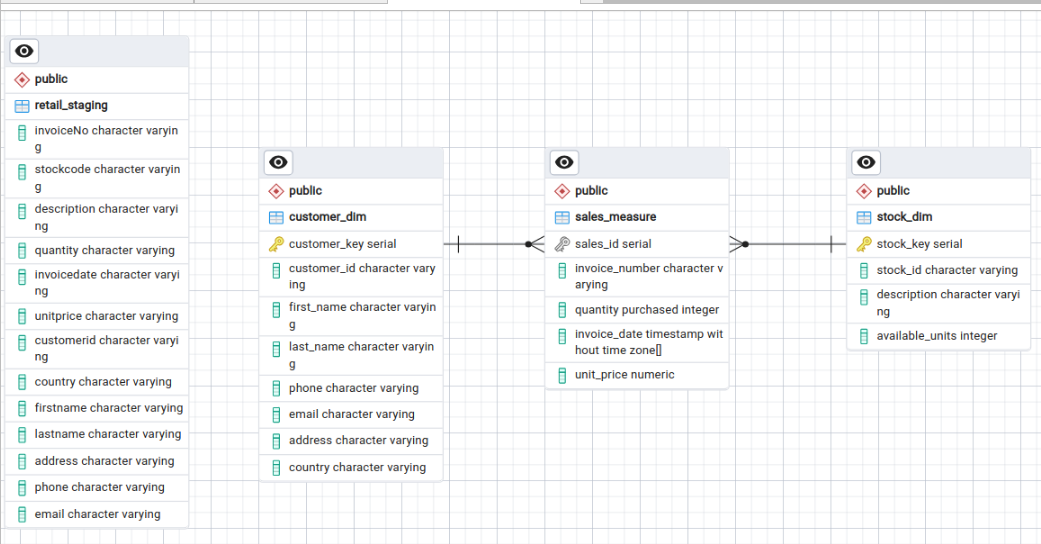

## 3.1.3 SQL and Bash Scripting

The conceptual database model created was forward engineered to generate the [SQL script](https://github.com/asoyewole/Datascience-Projects/blob/main/forward_engineered_table_creation_script.sql) for creating the database tables. Another [table_loading_script](https://github.com/asoyewole/Datascience-Projects/blob/main/table_loading_scripts.sql) was written to extract data from the staging table and load the two dimensions and the fact table. I did not generate data for the 'available units" field at the data augmentation stage. A code to generate data for this field was included in the table_loading_script.  

A bash script was written to execute all the SQL scripts. The postgreSQL password for accessing psql through the commandline was stored in a .pgpass file. It was therefore not necessary to include the password in the psql connection string. This way, if the dataset has regular updates with new events, the bash script would simply be set to run at regular intervals to update the database using crontab. In this case, a full load will be carried out whenever the bash script is executed. Incremental loading will be demonstrated in a different project.
  
  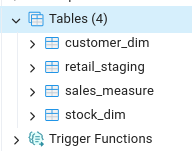  
    
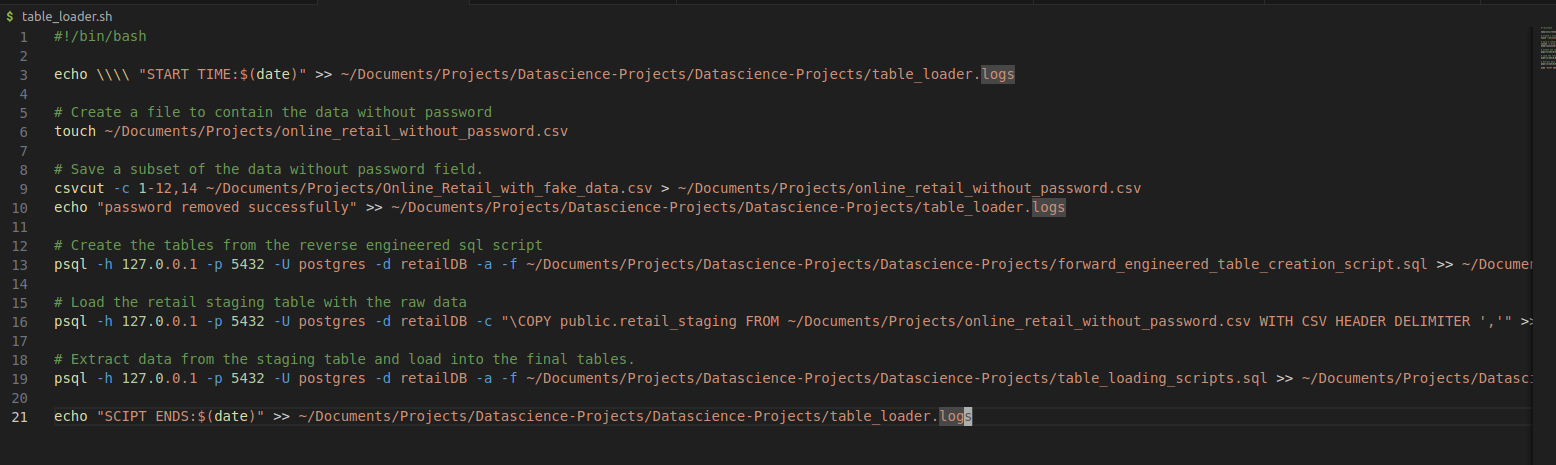  



# 4.0 Data Preparation  

The data needed for this analysis will be extracted from the database. For that a connection to the database is established using psycopg2. To avoid hard coding the password, an environment file is created in the same directory as this notebook. The password is saved in this file and loaded using os.getenv().

In [37]:
# Grab the password stored in .env file
load_dotenv()
pg_password = os.getenv('PASSWORD')
# Try connecting to the database
try:
    conn = psycopg2.connect(database = 'retailDB',
                                user = 'postgres',
                                password = pg_password,
                                host = 'localhost',
                                port = '5432')
    conn.autocommit = True
    cur = conn.cursor()
    print('Successfully connected')
except:
    print('connection failed')


Successfully connected


Using the connection already extablished, pandas read_sql function was used to extract the required data from the database using the sql statement saved as payload. Apparently pandas is more integrated with SQLAlchemy. I have still chosen to continue with psycopg2 becuase it interacts directly with the database and does not require translation of SQL codes as in the case of the SQLAlchemy engine. The user warning will thus be ignored.

In [38]:
try:
    payload = '''SELECT c.customer_id, c.country, 
                p.stock_id, p.description, 
                s."quantity purchased", s.invoice_number, s.invoice_date, s.unit_price
            FROM public.customer_dim as c
                LEFT JOIN public.stock_dim as p
                    ON c.customer_key=p.stock_key
                LEFT JOIN public.sales_measure as s
                    ON c.customer_key=s.sales_id'''

    df = pd.read_sql(payload, conn)

except:
    print('payload execution failed')
finally:
    cur.close()
    conn.close()

/tmp/ipykernel_2561/4008478741.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(payload, conn)


## 4.1 Exploratory Data Analysis
The data exploration will begin with the basics to identify the size of the data, review some samples of the data (head), and the data types (to modify where necessary). The numerical and non numerical aspects of the data are also described to review some summary statistics.


In [39]:
print(df.shape)
df.head()

(541909, 8)


,customer_id,country,stock_id,description,quantity purchased,invoice_number,invoice_date,unit_price
0,13047.0,United Kingdom,21754,HOME BUILDING BLOCK WORD,3,536367,2010-12-01 08:34:00,5.95
1,17850.0,United Kingdom,21871,SAVE THE PLANET MUG,6,536373,2010-12-01 09:02:00,1.06
2,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,536375,2010-12-01 09:32:00,3.39
3,14688.0,United Kingdom,21559,STRAWBERRY LUNCH BOX WITH CUTLERY,6,536378,2010-12-01 09:37:00,2.55
4,15311.0,United Kingdom,84854,GIRLY PINK TOOL SET,5,536381,2010-12-01 09:41:00,4.95


### 4.1.1 Data Types and Data Count

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         406829 non-null  object        
 1   country             541909 non-null  object        
 2   stock_id            541909 non-null  object        
 3   description         540455 non-null  object        
 4   quantity purchased  541909 non-null  int64         
 5   invoice_number      541909 non-null  object        
 6   invoice_date        541909 non-null  datetime64[ns]
 7   unit_price          541909 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


The description and customer_id fields both contain some missing values. These two columns will be reviewed intricately to handle their missing values. All other columns do not have null values. 

The field for customer_id, country, stock_id, description, and invoice_number are all of object data types. Country and Description are texts indicating the 'country' and the 'description of the product' respectively. Data type object correctly fits the purpose. While integer datatypes may appear to fit the other object columns, they actually contain alpha-numeric characters (except customer_id which will be reviewed further subsequently). Thus object data type is fitting.

From the top 5 records previously printed, some customer_id are repeated for different records. This indicates multiple purchases. A customer may purchase more than one product.

The data description from the UCI repository also indicated that some invoice numbers start with 'C' to indicate canceled transactions.

### 4.1.2 Summary Statistics and Dispersion

In [41]:
# Describe quantitative variables
df.describe()

,quantity purchased,invoice_date,unit_price
count,541909.000000,541909,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 17:17:00,2.080000
75%,10.000000,2011-10-19 11:27:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.081158,NaN,96.759853


Quantity purchased, which represents the number of the product that was purchased has a mean of 9.55 and ranged between -80,995 and 80,995. The negative values indicate returned products or cancelled orders. With a standard deviation of 218, the data distribution is significantly dispersed around the mean.

The invoice date ranged from Dec 1, 2010 at 8:30am to Dec 9, 2011 at 12:50pm. The invoice date represents the timestamp of when the transaction occurred. 

The unit price also has negative values which may also have been used to express returned products. The maximum and minimum values of unit price are also large at 38,970 and -11,062 respectively. the standard deviation of 96.76 indicates significant dispersion of the data around the mean. 

In [42]:
# Describe numerical variables
df.describe(include='object')

,customer_id,country,stock_id,description,invoice_number
count,406829,541909,541909,540455,541909
unique,4372,38,4070,4223,25900
top,17841.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,573585
freq,7983,495478,2313,2369,1114


As previously indicated, the customer_id has 406,829 values, a difference of over 135,000 values from the columns with the highest number of records. There are about 4,300 unique customer_id. The customer with the highest number of transactions has almost 8,000 transactions.

The clients of this online retail company visit from 38 countries. Visitors from the UK account for more than 90% of their client base.

There are more than 4,000 unique stock_id representing the individual products. One of the stock_id has a frequency of 2,313. This could be the highest selling product. The summary figures for description are similar with those for stock_id.

There are almost 26,000 invoices. Some of the invoice numbers are also repeated since multiple products can be purchased on the same invoice.

## 4.2 Data Cleansing
Some missing values have already been identified in the data. They will be handled in this section. The dataset will also be reviewed to identify duplicates and treat them as necessary. They will be reviewed to identify if they are repeat transactions or duplicate transaction records for the same transaction.

### 4.2.1 Missing Data

In [43]:
null = df.isnull().sum()
null

customer_id           135080
country                    0
stock_id                   0
description             1454
quantity purchased         0
invoice_number             0
invoice_date               0
unit_price                 0
dtype: int64

In [44]:
#Obtain the percentage of null values per column and sort in descending order
percent_null = ((null/df.shape[0]) * 100).round(2).sort_values(ascending = False)
percent_null

customer_id           24.93
description            0.27
country                0.00
stock_id               0.00
quantity purchased     0.00
invoice_number         0.00
invoice_date           0.00
unit_price             0.00
dtype: float64

From the two cells above, it is confirmed that only fields customer_id and description have missing values. 

24.93% of customer_id has missing values. Considering the analysis is about segmenting customers, the missing values cannot be filled based on any of the data filling techniques (mean values, forward filling etc). It is expedient to use only factual data expecially for the customers so that the customer behaviors can be identified clearly by the algorithm. Filling in the missing data for customer id will only introduce noise into the dataset. Even though 24.93% of the data represents over 135 thousand records, there will still be 406 thousand rows left which is enough for our analysis. The records with missing customer id will therefore be removed.

Only 0.27% of description field is missing. This is just 1,400 rows. If there were significantly more missing rows, it may have been possible to review the stock code and attempt to propagate the missing values. However, removing 1,400 rows from 406,000 fields will still leave us with enough data to complete the analysis. Description with missing values will therefore also be removed.

In [45]:
# Drop all null values
df = df.dropna()

# Confirm if any null value is left
print(df.isnull().sum())

# Verify shape of remaining dataframe
df.shape


customer_id           0
country               0
stock_id              0
description           0
quantity purchased    0
invoice_number        0
invoice_date          0
unit_price            0
dtype: int64


(406829, 8)

### 4.2.2 Duplicate Data
In this section, the dataset will be examined for duplicates using pandas .duplicated function. The duplicate data will subsequently be handled.

In [46]:
print(f'there are {df.duplicated().sum()} duplicates in the dataset.')
      
# Review top 20 duplicates to see if they are repeat transactions
    #multiple transactions occurred at the same time, so we cannot sort by invoice_date alone.
duplicates = df[df.duplicated(keep=False)]
duplicates.sort_values(by=['invoice_date', 'stock_id', 'invoice_number']).head(20)

there are 5225 duplicates in the dataset.


,customer_id,country,stock_id,description,quantity purchased,invoice_number,invoice_date,unit_price
31,17908.0,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1,536409,2010-12-01 11:45:00,1.25
474551,17908.0,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1,536409,2010-12-01 11:45:00,1.25
169085,17908.0,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,1,536409,2010-12-01 11:45:00,4.95
270628,17908.0,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,1,536409,2010-12-01 11:45:00,4.95
33890,17908.0,United Kingdom,22866,HAND WARMER SCOTTY DOG DESIGN,1,536409,2010-12-01 11:45:00,2.10
474553,17908.0,United Kingdom,22866,HAND WARMER SCOTTY DOG DESIGN,1,536409,2010-12-01 11:45:00,2.10
32,17908.0,United Kingdom,22900,SET 2 TEA TOWELS I LOVE LONDON,1,536409,2010-12-01 11:45:00,2.95
33,17908.0,United Kingdom,22900,SET 2 TEA TOWELS I LOVE LONDON,1,536409,2010-12-01 11:45:00,2.95
33897,17920.0,United Kingdom,21448,12 DAISY PEGS IN WOOD BOX,2,536412,2010-12-01 11:49:00,1.65
169088,17920.0,United Kingdom,21448,12 DAISY PEGS IN WOOD BOX,2,536412,2010-12-01 11:49:00,1.65


There are 5,225 duplicate transactions identified. A cursory view across the top 20 transactions reveal that they are most likely data entry errors. The stock_id, invoice_number, customer_id and even date (timestamp) of these transactions are exactly the same. The duplicates will therefore be removed to leave a cleaner dataset. The presence of duplicates may influence the behavioural characteristics identified by the algorithm.

In [47]:
df = df.drop_duplicates()
df.shape

(401604, 8)

### 4.2.3 Zero Unit Price
At the quantitative summary section, the minimum value for unit price was zero. This could mean there are some free items or it could be an error in the dataset. The summary statistic of items where unit price is zero is described below.

In [48]:
print(f'there are {(df.unit_price==0).sum()} records with zero price')

# Summary statistic for 'quantity purchased' of records with zero unit price
df[df.unit_price==0].describe()[['quantity purchased']]

there are 40 records with zero price


,quantity purchased
count,40.000000
mean,347.100000
min,1.000000
25%,1.000000
50%,4.500000
75%,24.000000
max,12540.000000
std,1978.311813


The summary above indicates that there are 40 records with zero unit price. The corresponding quantity range from 1 to 12,540. The mean and standard deviations are also large. I consider it unlikely that this number of products would have been given out for free as individual transactions. Therefore the records with unit price of zero will be dropped.

In [49]:
df = df[df['unit_price'] > 0]
df.shape

(401564, 8)

## 4.2.4 Cancelled Transactions and Amount Spent

The data record from the UCI repository specified that cancelled transactions have invoice numbers starting with C. Based on this quality, a new column will be inserted to identify cancelled transactions.

The amount spent by each customer will be computed from the unit price for the products they purchased and the number of products. This would give an overview of the customer's purchase habits and how much they spend per transaction.

In [50]:
df['cancelled_transaction'] = df['invoice_number'].map(lambda a:0 if a[0]=='C' else 0)
df['transaction_spend'] = df['unit_price'] * df['quantity purchased']

# 4.2.5 Date Splitting
The invoice date in the data set will be split into units including day, month and year. Analyzing by these units will help to identify seasonal trends in customer's purchase behaviours.

In [51]:
def timeframe(period):
    '''function to group time to morning, afternoon, evening, and night
    PARAMETER - period: time input to classify
    returns: time_frame(morning, afternoon, evening, night)'''
    
    if 0<=period<=6: time_frame = 'night'
    elif 6<=period<=12: time_frame = 'morning' 
    elif 12<=period<=18: time_frame = 'afternoon'
    else: time_frame = 'evening' 
    return time_frame

df['day'] = df.invoice_date.dt.day
df['month'] = df.invoice_date.dt.month
df['weekday'] = df.invoice_date.dt.day_name()
df['timeframe'] = df.invoice_date.dt.hour.map(timeframe)

## 4.3 Feature Engineering

The feature engineering will start with the trio of recency, frequency and monatary, the features commonly used for segmentation analysis. Recency relates to how recently a customer has made a purchase and will be deduced from the invoice date. The frequency features identifies how often a customer makes a purchase while monetary features measures the total amount spent by the customer.

### 4.3.1 Recency
Recency will be estimated by deducting the latest day that each customer purchased from the latest date in the dataset.

In [52]:
# Extract the date from the timestamp - invoice date
df['invoice_day'] = df['invoice_date'].dt.date

# The most recent purchase date for each customer
df_customer = df.groupby('customer_id')['invoice_day'].max().reset_index() # Reset index to make it a dataframe instead of series.
df_customer['invoice_day'] = pd.to_datetime(df_customer['invoice_day'])

# # The maximum date in the dataset
max_date = pd.to_datetime(df.invoice_day.max())


# # Calculate the days since customer last purchased (recency)
df_customer['recency'] = (max_date - df_customer['invoice_day']).dt.days

# Drop the column invoice day
df_customer = df_customer.drop(columns='invoice_day')

df_customer.head()

,customer_id,recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


### 4.3.2 Frequency
The frequency of purchase will be estimated by extracting the number of transactions (ie number of invoices) per customer, and then the total number of products purchased.

In [53]:
# Obtaining the number of transactions for each customer, rename column
df_freq1 = df.groupby('customer_id')['invoice_number'].nunique().reset_index()
df_freq1 = df_freq1.rename(columns={'invoice_number' : 'transaction_volume'})

# Obtaining the total quantity of products purchased per customer
df_freq2 = df.groupby('customer_id')['quantity purchased'].sum().sort_values().reset_index()

# Add the new information into the customer dataframe.
df_customer = pd.merge(df_customer, df_freq1, on='customer_id')
df_customer = pd.merge(df_customer, df_freq2, on='customer_id')

df_customer.head()

,customer_id,recency,transaction_volume,quantity purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2341
3,12349.0,18,1,631
4,12350.0,310,1,197


### 4.3.3 Monetary
The monetary value of each customer's group of transactions will be expressed in terms of the total amount spent; and the average amount spent per transaction

In [54]:
df['total_amt_spent'] = df['unit_price'] * df['quantity purchased']

df_mon = df.groupby('customer_id')['total_amt_spent'].sum().reset_index()

df_customer = pd.merge(df_customer, df_mon, on='customer_id')

df_customer['average_spend'] = df_customer['total_amt_spent']/df_customer['transaction_volume']

# df_customer.drop(columns=['total_amt_spent_x', 'total_amt_spent_y'], inplace=True)

df_customer.head()

,customer_id,recency,transaction_volume,quantity purchased,total_amt_spent,average_spend
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2341,1797.24,449.310000
3,12349.0,18,1,631,1757.55,1757.550000
4,12350.0,310,1,197,334.40,334.400000


### 4.3.4 Unique Products Purchased
The number of different products purchased will give a viewpoint of each customer's product preferences.

In [55]:
df_diff = df.groupby('customer_id')['stock_id'].nunique().reset_index()
df_diff = df_diff.rename(columns={'stock_id' : 'unique_purchases'})
df_customer = pd.merge(df_customer, df_diff, on='customer_id')
df_customer.head()

,customer_id,recency,transaction_volume,quantity purchased,total_amt_spent,average_spend,unique_purchases
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2341,1797.24,449.310000,22
3,12349.0,18,1,631,1757.55,1757.550000,73
4,12350.0,310,1,197,334.40,334.400000,17


In [56]:
df.invoice_number.unique()
df['cancelled_transaction'] = df['invoice_number'].map(lambda a:1 if a[0]=='C' else 0)
cancelled = df[df['cancelled_transaction'] == 1]
cancel_per_customer = cancelled.groupby('customer_id')['invoice_number'].nunique().reset_index()

cancel_per_customer.rename(columns = {'invoice_number': 'cancel_freq'}, inplace = True)

df_customer = pd.merge(df_customer, cancel_per_customer, on = 'customer_id', how = 'left')

# df_customer.drop(columns = ['cancel_freq_x', 'cancel_freq_y', 'cancel_freq'], inplace=True)

df_customer['cancel_freq'] = df_customer['cancel_freq'].fillna(0)

df_customer.head()

,customer_id,recency,transaction_volume,quantity purchased,total_amt_spent,average_spend,unique_purchases,cancel_freq
0,12346.0,325,2,0,0.00,0.000000,1,1.0
1,12347.0,2,7,2458,4310.00,615.714286,103,0.0
2,12348.0,75,4,2341,1797.24,449.310000,22,0.0
3,12349.0,18,1,631,1757.55,1757.550000,73,0.0
4,12350.0,310,1,197,334.40,334.400000,17,0.0


# 5.0 Modelling
K-Means clustering will be used to group the customer data into clusters. 

## 5.1 Feature Scaling

The wide range of some columns in the dataset will influence the model result if used in a k-means clustering model. As such, the numerical data must first be scaled. Standard scaler will be used for this purpose.

In [57]:
scaler = StandardScaler()

scale_data = df_customer.drop(columns = 'customer_id')
scaled_data = scaler.fit_transform(scale_data)

scaled_data = pd.DataFrame(scaled_data, index = scale_data.index, columns = scale_data.columns)

scaled_data.head()

,recency,transaction_volume,quantity purchased,total_amt_spent,average_spend,unique_purchases,cancel_freq
0,2.316284,-0.329608,-0.239419,-0.230447,-0.871617,-0.705035,0.076741
1,-0.889184,0.206214,0.287803,0.293970,0.834333,0.489090,-0.391088
2,-0.164729,-0.115280,0.262708,-0.011769,0.373279,-0.459186,-0.391088
3,-0.730400,-0.436773,-0.104075,-0.016598,3.997998,0.137877,-0.391088
4,2.167423,-0.436773,-0.197164,-0.189759,0.054900,-0.517721,-0.391088


## 5.2 Principal Component Analysis
Since clustering is essentially distance-based modelling with data instances plotted on a feature space, it works best with fewer dimensions. Although, our dataset has been reduced to 7 dimensions through feature engineering, employing PCA will enable a further reduction in the number of dimensions while retaining the important information within them.

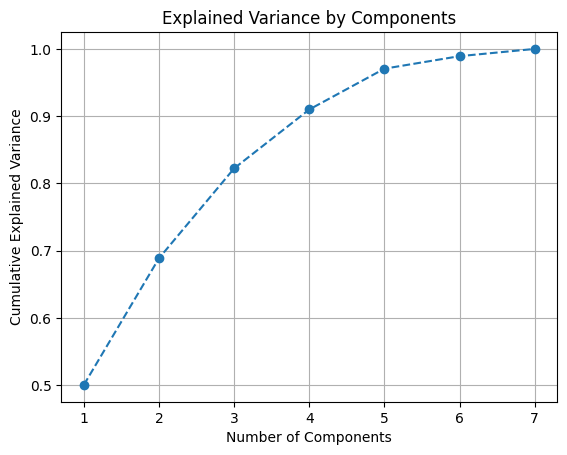

In [65]:
pca = PCA()
pca.fit(scaled_data)

evr = pca.explained_variance_ratio_
x_axis = range(1, scaled_data.shape[1]+1)
plt.plot(x_axis, evr.cumsum(), marker='o', linestyle = '--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid();

More than 80% of the variance can be explained by only 3 components, 4 components explains about 90% of the variance and 5 components already explain close to 100% of the variance. The performance using 4 and 5 components respectively will be compared to select the optimal one.

In [70]:
pca_5 = PCA(n_components=5)
pca_4 = PCA(n_components=4)
pca_3 = PCA(n_components=3)


pca_5_scores = pca_5.fit_transform(scaled_data)
pca_4_scores = pca_4.fit_transform(scaled_data)
pca_3_scores = pca_3.fit_transform(scaled_data)

## 5.3 K-Means Clustering


## 5.3.1 Number of Clusters
The optimal number of clusters must be determined for the dataset. This will be passed as a parameter to the clustering model. The number of clusters with the highest silhouette score will be reviewed to determine the number of clusters. Ideally, the number of clusters will be compared with existing domain knowledge to make an optimal informed choice.

In [82]:
cluster_range = list(range(3,11))
pca5_sil_scores = []
pca4_sil_scores = []
pca3_sil_scores = []

for cluster in cluster_range:
    clusterer = KMeans(n_clusters=cluster, random_state=42)
    pca5_cluster_labels = clusterer.fit_predict(pca_5_scores)
    pca5_sil_score = silhouette_score(pca_5_scores, labels=pca5_cluster_labels)
    pca5_sil_scores.append(pca5_sil_score)
    
    pca4_cluster_labels = clusterer.fit_predict(pca_4_scores)
    pca4_sil_score = silhouette_score(pca_4_scores, labels=pca4_cluster_labels)
    pca4_sil_scores.append(pca4_sil_score)
    
    pca3_cluster_labels = clusterer.fit_predict(pca_3_scores)
    pca3_sil_score = silhouette_score(pca_3_scores, labels=pca3_cluster_labels)
    pca3_sil_scores.append(pca3_sil_score)
    
print(pca5_sil_scores)
print(pca4_sil_scores)
print(pca3_sil_scores)

[0.46535904443891307, 0.4656582856406198, 0.4594796850948445, 0.42327671041327747, 0.4247063117022989, 0.3896650238980121, 0.2983012399525032, 0.3114143727476655]
[0.37902047543238376, 0.4419376210105872, 0.44287660844719334, 0.43489105658848376, 0.42165665901037375, 0.3212126117466293, 0.3287704936190754, 0.3297123496115719]
[0.505634085422709, 0.468333211519352, 0.47024970664746235, 0.4044541237341401, 0.40521142781083025, 0.4092377217624849, 0.3146529485126667, 0.3320309874101467]


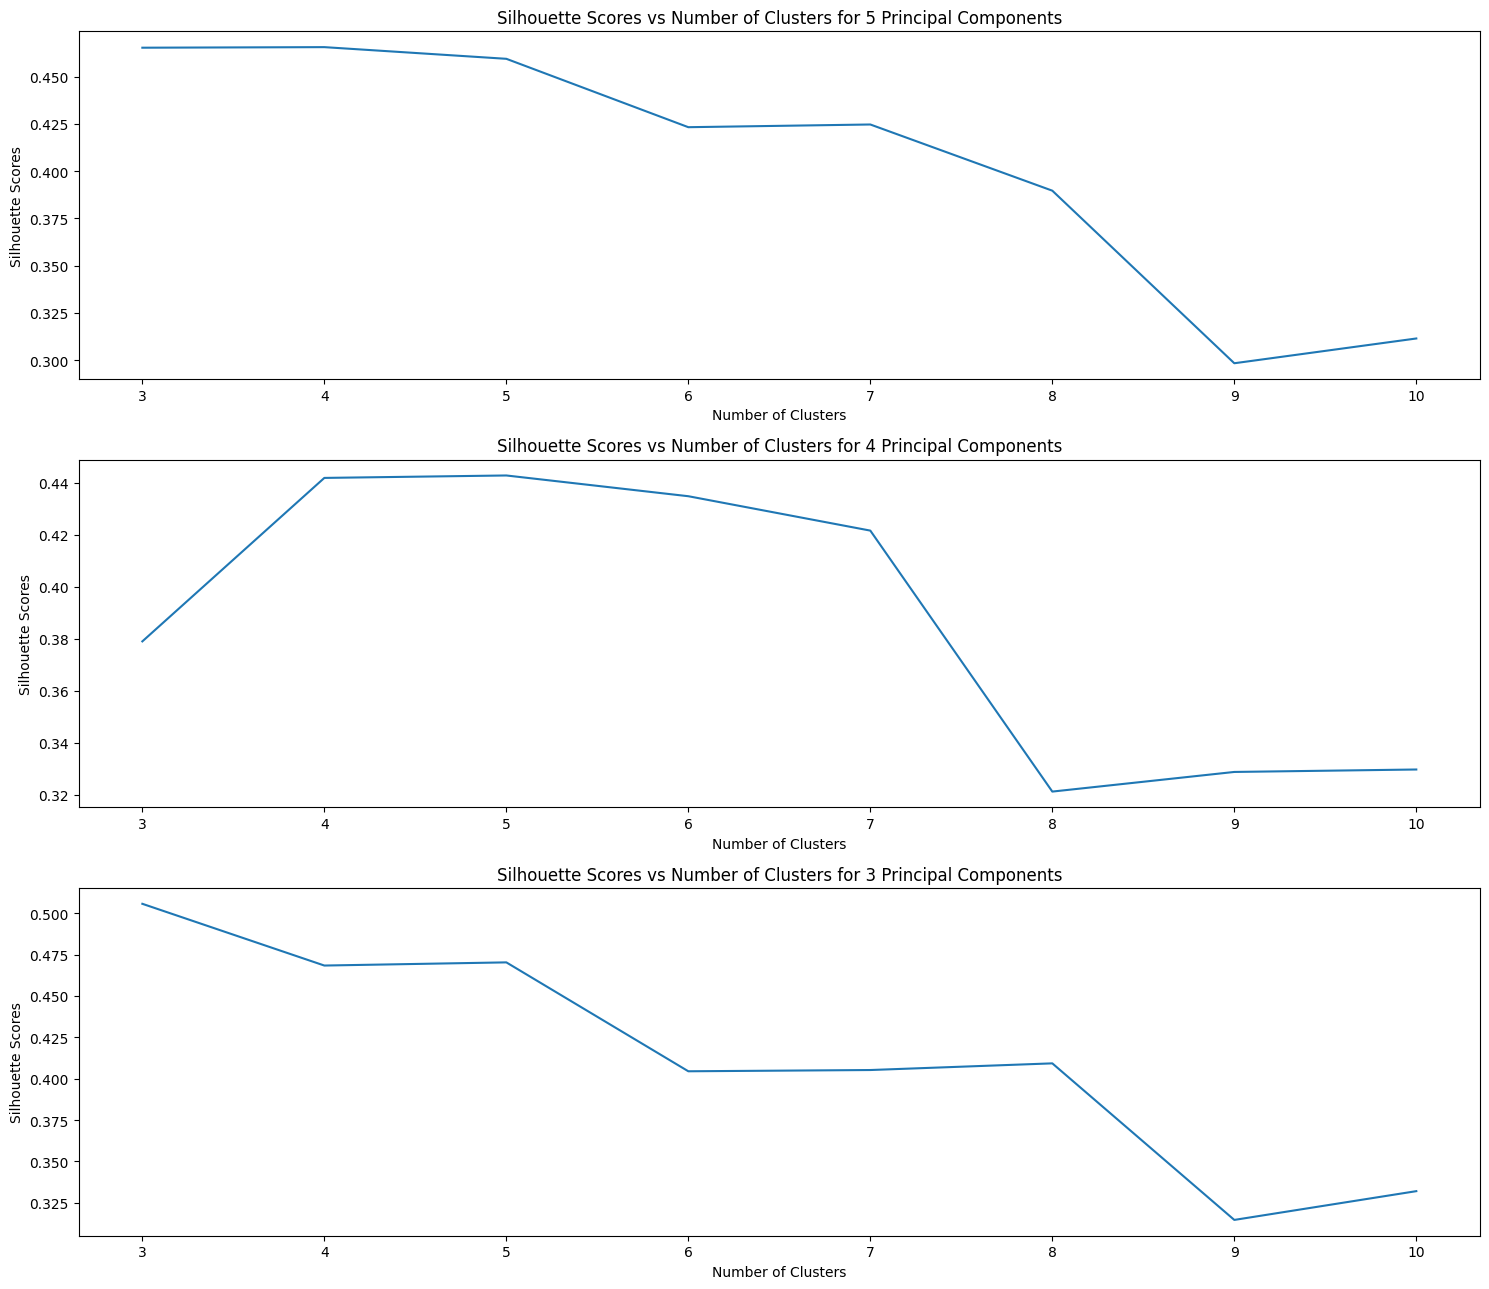

In [89]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (15,13))

ax[0].plot(cluster_range, pca5_sil_scores)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Silhouette Scores')
ax[0].set_title('Silhouette Scores vs Number of Clusters for 5 Principal Components')

ax[1].plot(cluster_range, pca4_sil_scores)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouette Scores')
ax[1].set_title('Silhouette Scores vs Number of Clusters for 4 Principal Components')

ax[2].plot(cluster_range, pca3_sil_scores)
ax[2].set_xlabel('Number of Clusters')
ax[2].set_ylabel('Silhouette Scores')
ax[2].set_title('Silhouette Scores vs Number of Clusters for 3 Principal Components')

plt.tight_layout();

Considering the silhouette scores plot for each selection of principal components, setting K=3 for 3 principall components gives the global highest silhouette score of 0.51. This combination will be selected as the optimal number of clusters and number of components.

## 5.3.2 Clustering

In [92]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=42)
kmeans.fit(pca_3_scores)

labels = kmeans.labels_
df_customer['segments'] = labels



In [93]:
df_customer.head()

,customer_id,recency,transaction_volume,quantity purchased,total_amt_spent,average_spend,unique_purchases,cancel_freq,segments
0,12346.0,325,2,0,0.00,0.000000,1,1.0,0
1,12347.0,2,7,2458,4310.00,615.714286,103,0.0,2
2,12348.0,75,4,2341,1797.24,449.310000,22,0.0,2
3,12349.0,18,1,631,1757.55,1757.550000,73,0.0,2
4,12350.0,310,1,197,334.40,334.400000,17,0.0,0


## 3.5.3 Cluster Analysis

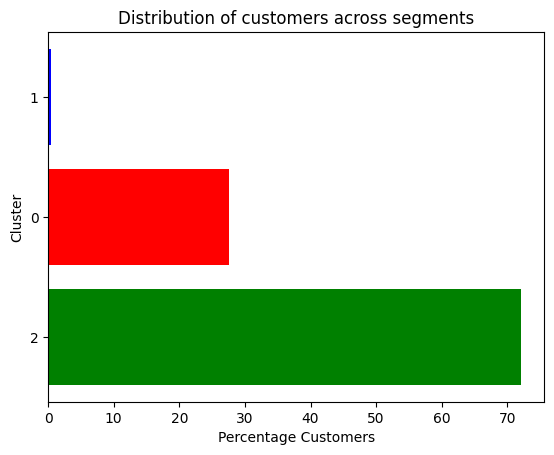

In [125]:
colors= ['green', 'red', 'blue']

segment_counts = df_customer['segments'].value_counts(normalize=True) * 100
segment_counts_index = segment_counts.index.astype(str)

plt.barh(segment_counts_index, segment_counts.values, color = colors)
plt.title('Distribution of customers across segments')
plt.ylabel('Cluster')
plt.xlabel('Percentage Customers');

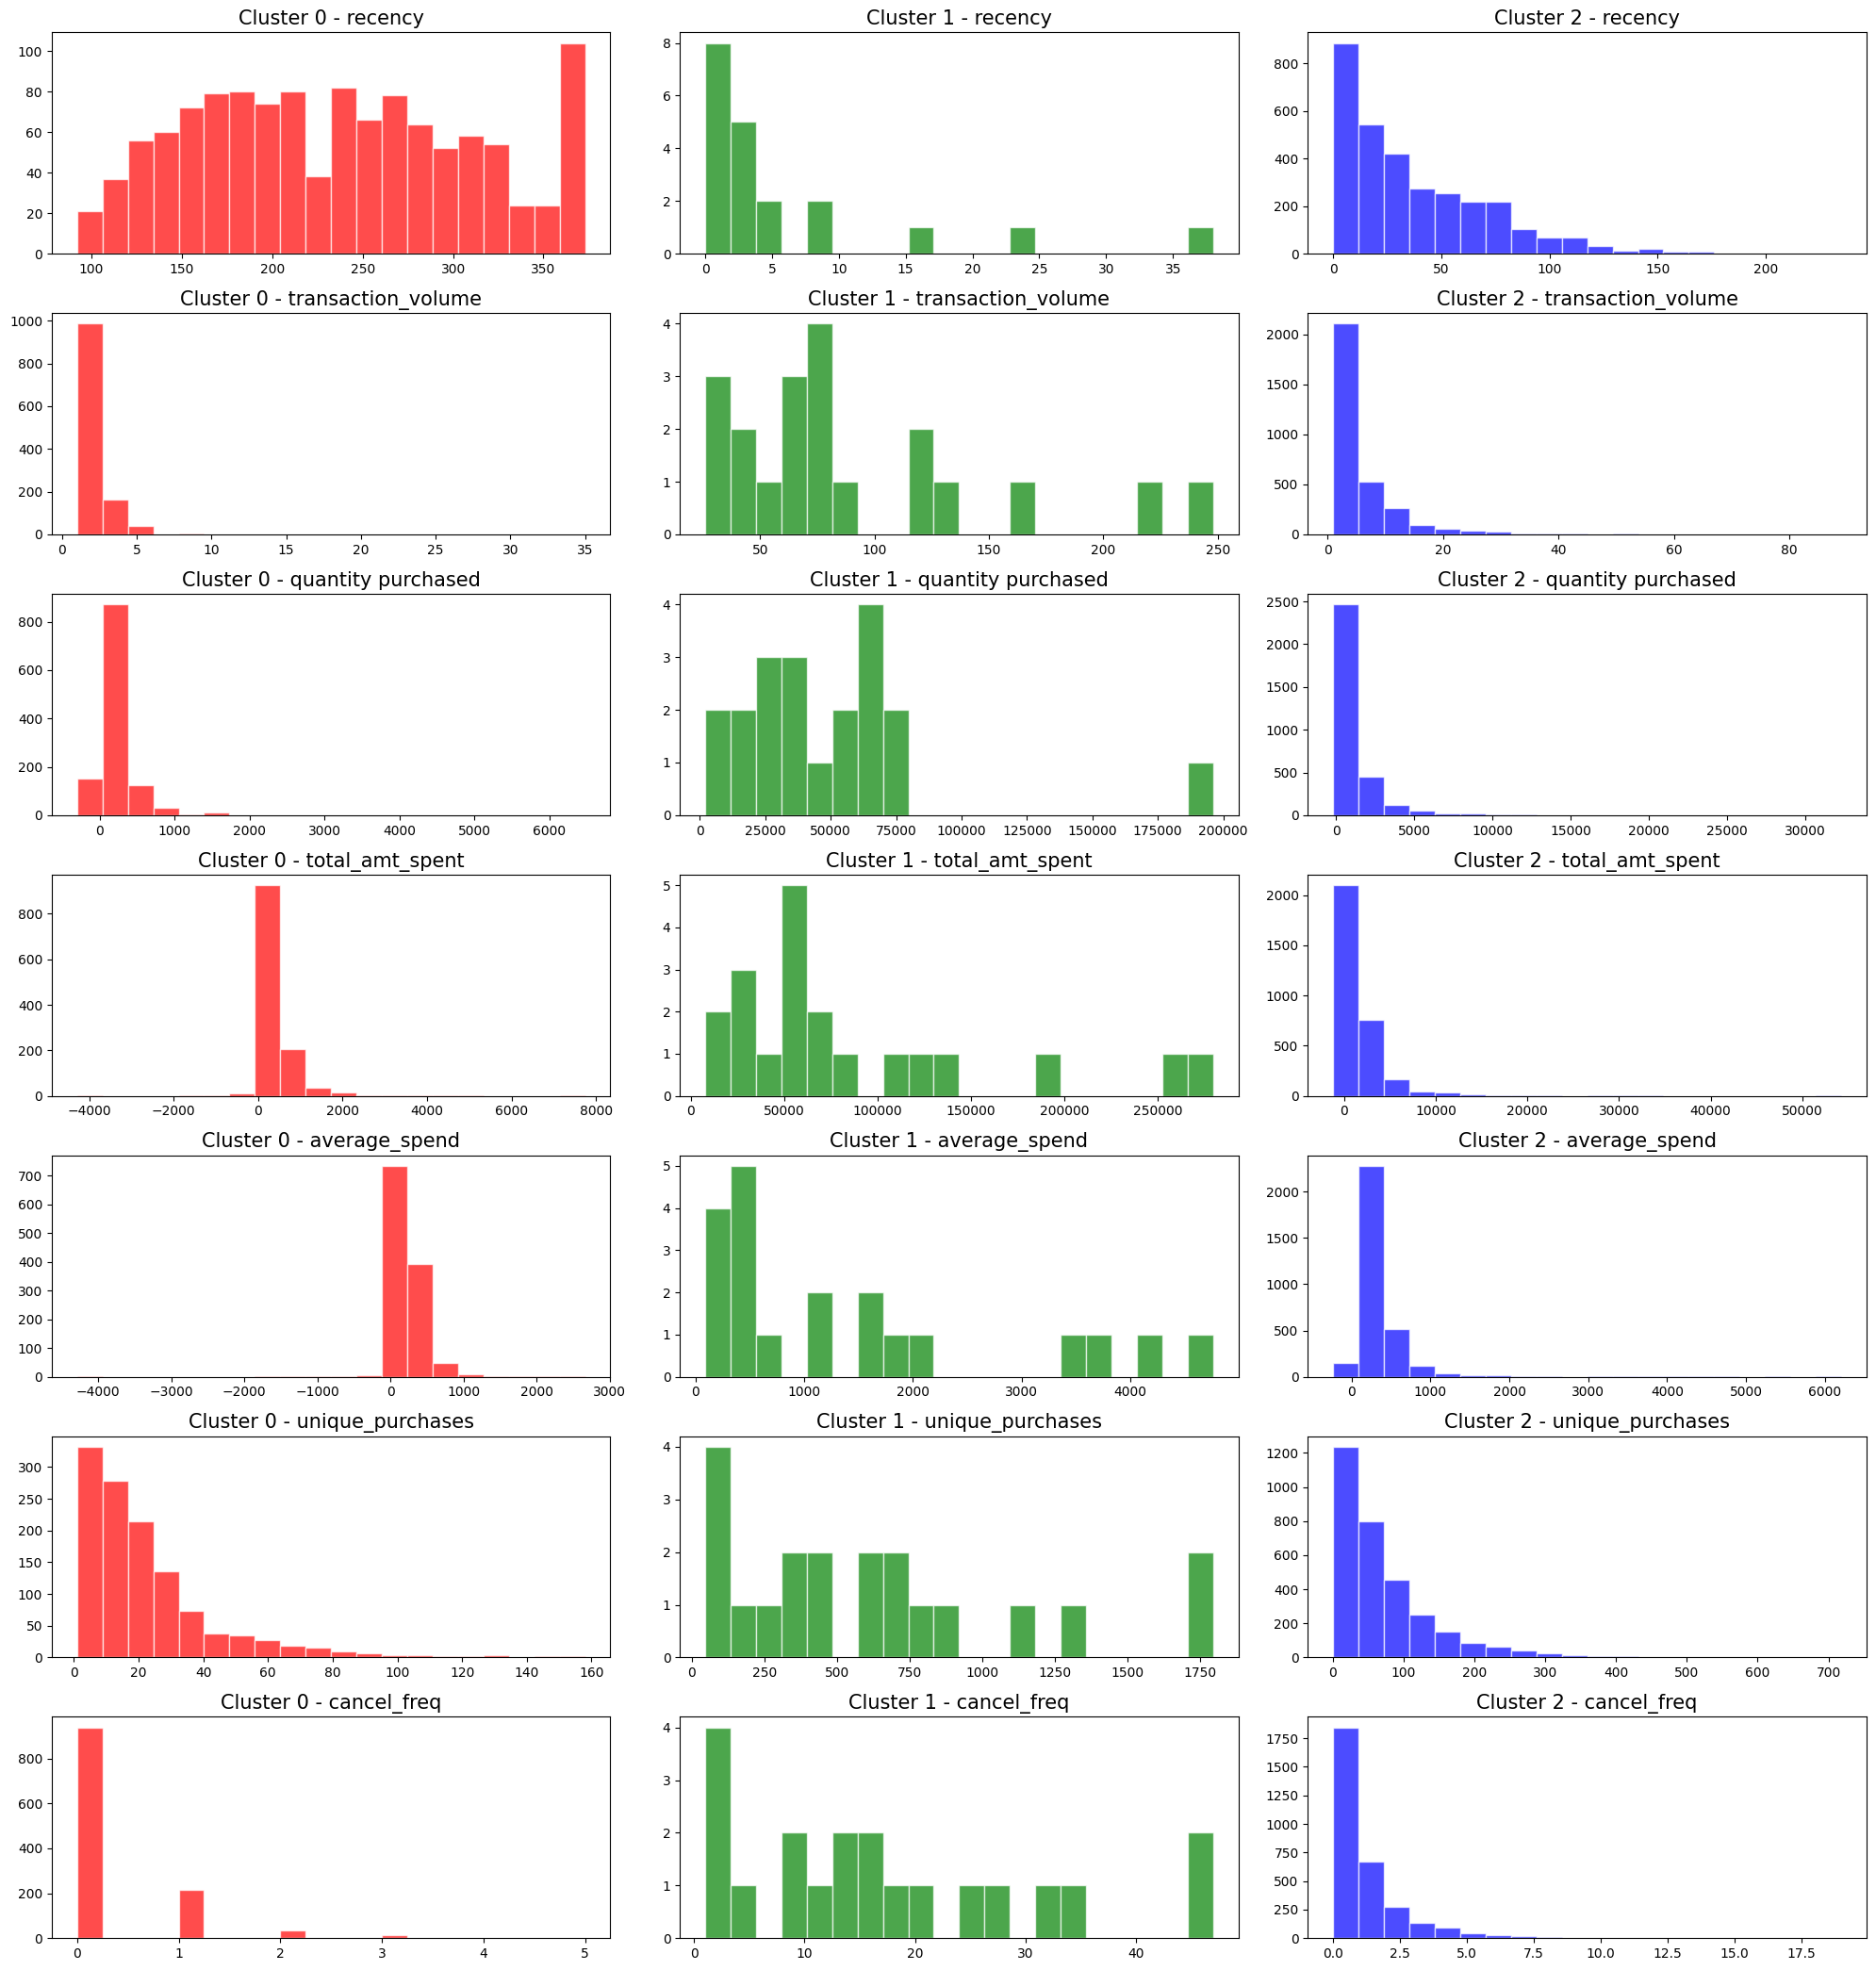

In [95]:
features = df_customer.columns[1:-1]
clusters = df_customer['segments'].unique()
clusters.sort()
colors = ['red', 'green', 'blue']

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = df_customer[df_customer['segments'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

## Characteristics of Each Segment

**Segment 0**  
Occassional shoppers with average transaction volume. Their total spend is comparatively average, and they seldom cancel their transactions. They have the highest likelihood of returning their puchases.

**Segment 1**  
One off shoppers fall into this segment. They have generally low transaction volume, and purchase quantities. They also have low cancelation frequency and the least spread of unique products purchased across the segments. 
  
**Segment 2**   
They are regular shoppers who show a preference for quality products, given their transaction volumes. They spend the most among the segments and buy the largest range of unique products. Their cancelation frequency is also comparatively high.

# Conclusion  
In this project, I explored the sales data of an online retail company. I engineered features from the data and used that to cluster the company's customers into three segments. The attributes and characteristics of each segments were uncovered through exploration. In order to optimize the performance of the clustering model, the duo of standardization and principal component analysis were employed. A new feature was deduced from the model, which represents the segment that each customer falls in. A classification system can be based on this feature to determine which segment a new customer falls in. This will help the company to target advertisements, develop product groups, and recommend products to new customers based on their behaviour, and classified segments.